In [1]:
'''
载入分析中需要使用的包，并设置显示与绘图环境
'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['font.sans-serif'] = ["simhei","Whitney Book"]
pd.set_option('display.precision', 2)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
shops = pd.read_excel('data/shops.xlsx')
comments = pd.read_excel('data/comment.xlsx')
coupon = pd.read_excel('data/coupon.xlsx')

In [4]:
# 选择郑州火锅门店信息
shops_zzhp = shops[(shops['关键词']=='火锅') & (shops['城市']=='zz')]

In [5]:
# 去除一行记录内超过4个NaN的数据
shops_zzhp.dropna(thresh=4,axis=0,inplace=True)

In [6]:
# 去除混进的非火锅商家数据
for index, row in shops_zzhp.iterrows():
    if ('康吉利' in row['店名']):
        shops_zzhp.drop(index,axis=0,inplace=True)
    if ('林家咖啡' in row['店名']):
        shops_zzhp.drop(index,axis=0,inplace=True)
    if ('泡馍包子城' in row['店名']):
        shops_zzhp.drop(index,axis=0,inplace=True)
    if ('花雕醉鸡' in row['店名']):
        shops_zzhp.drop(index,axis=0,inplace=True)

In [7]:
shops_zzhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 190 to 589
Data columns (total 9 columns):
店名      395 non-null object
关键词     395 non-null object
城市      395 non-null object
评分      395 non-null float64
评价数     395 non-null float64
人均      395 non-null object
地址      395 non-null object
营业时间    395 non-null object
菜名      395 non-null object
dtypes: float64(2), object(7)
memory usage: 30.9+ KB


In [8]:
# 将人均消费数据转为float型
shops_zzhp['人均'] = shops_zzhp['人均'].astype(float)

In [9]:
shops_zzhp['评价数'].median()

67.0

In [10]:
shops_zzhp.describe()

,评分,评价数,人均
count,395.00,395.00,395.00
mean,3.96,278.35,47.71
std,1.51,672.29,30.33
min,0.00,0.00,14.00
25%,4.25,4.50,31.00
50%,4.50,67.00,40.50
75%,4.70,271.50,53.75
max,5.00,7665.00,375.00


In [11]:
# 提取郑州团购信息
coupon_zz = coupon[coupon['地址'].str.contains('郑州')==True]

In [63]:
# 对比shop（郑州火锅）-coupon（郑州）两表
# 筛选出郑州火锅团购活动
coupon_zzhp = coupon_zz.copy()
for index,row in coupon_zzhp.iterrows():
    if(not row['店名'] in shops_zzhp['店名'].values):
        coupon_zzhp.drop(index,axis=0,inplace=True)

In [64]:
# 用shop中的准确地址信息 修补coupon表中的数据错误
for index,row in coupon_zzhp.iterrows():
    coupon_zzhp.loc[index,'地址']=shops_zzhp.loc[shops_zzhp['店名']==row['店名'],'地址'].values[0]

In [65]:
# 有数十个团购没有显示团购价、市场价
# 通过提取团购介绍中的文字筛选出团购价格/市场价格，进行缺失值插补
for index,row in coupon_zzhp.iterrows():
    if(np.isnan(row['团购价'])):
        coupon_zzhp.loc[index,'团购价'] = float(row['团购介绍'].split('仅售')[1].split('元')[0])
    if(np.isnan(row['市场价'])):
        coupon_zzhp.loc[index,'市场价'] = float(row['团购介绍'].split('价值')[1].split('元')[0])

In [66]:
coupon_zzhp.loc[coupon_zzhp['评价人数'].str.isnumeric()==False,'团购评价']=0
coupon_zzhp.loc[coupon_zzhp['评价人数'].str.isnumeric()==False,'评价人数']=0

In [67]:
coupon_zzhp['团购评价']=coupon_zzhp['团购评价'].astype(float)
coupon_zzhp['评价人数']=coupon_zzhp['评价人数'].astype(int)

In [17]:
coupon_zzhp[coupon_zzhp['评价人数']>0].median()

团购活动ID    1.25e+07
购买人数      1.24e+02
团购评价      4.60e+00
评价人数      1.30e+01
团购价       9.80e+01
市场价       1.31e+02
dtype: float64

In [68]:
coupon_zzhp['到期时间'] = pd.to_datetime(coupon_zzhp['到期时间'])

In [69]:
coupon_zzhp['到期时间'].min()

Timestamp('2018-08-01 00:00:00')

In [20]:
coupon_zzhp['到期时间'].max()

Timestamp('2023-01-03 00:00:00')

In [70]:
coupon_zzhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 485 to 1550
Data columns (total 14 columns):
团购名       1034 non-null object
店名        1034 non-null object
团购活动ID    1034 non-null int64
团购介绍      1034 non-null object
购买人数      1034 non-null int64
团购评价      1034 non-null float64
评价人数      1034 non-null int32
到期时间      1034 non-null datetime64[ns]
团购价       1034 non-null float64
市场价       1034 non-null float64
地址        1034 non-null object
团购内容      1011 non-null object
备注        1027 non-null object
购买须知      1027 non-null object
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(7)
memory usage: 157.1+ KB


In [22]:
# 对比shop（郑州火锅）-comments两表
# 筛选出郑州火锅评价信息
comments_zzhp = comments.copy()
for index,row in comments.iterrows():
    if (not row['团购活动ID'] in coupon_zzhp['团购活动ID'].values):
        comments_zzhp.drop(index, axis=0, inplace=True)

In [24]:
# 删除重复数据
comments_zzhp.drop_duplicates(inplace = True)

In [25]:
# 有三千余个评价信息中缺失门店信息
# 通过表间对应进行插补
for index,row in comments_zzhp[comments_zzhp['消费门店'].isnull()].iterrows():
    comments_zzhp.loc[index,'消费门店'] = coupon_zzhp.loc[coupon_zzhp['团购活动ID']==row['团购活动ID'],'店名'].values[0]

In [26]:
comments_zzhp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38567 entries, 0 to 77272
Data columns (total 8 columns):
团购活动ID    38567 non-null int64
用户ID      38567 non-null int64
用户名       38567 non-null object
评价时间      38567 non-null object
评价内容      28080 non-null object
评分        38567 non-null int64
消费门店      38567 non-null object
用户排名      38567 non-null int64
dtypes: int64(4), object(4)
memory usage: 3.9+ MB


In [27]:
comments_zzhp.describe()

,团购活动ID,用户ID,评分,用户排名
count,3.86e+04,3.86e+04,38567.00,38567.0
mean,8.60e+06,3.70e+08,4.55,6788.9
std,1.02e+07,5.34e+07,0.94,2232.3
min,3.16e+05,8.31e+07,1.00,2247.0
25%,3.19e+06,3.49e+08,4.00,6355.0
50%,4.62e+06,3.77e+08,5.00,6939.0
75%,7.75e+06,3.97e+08,5.00,8496.0
max,4.12e+07,4.38e+08,5.00,10760.0


## 爆款/冷门分别有哪些特点？（同时与同业比较）
* 爆款/冷门定义：团购产品**月均购买人数**位居前10%
*   以**有效期起始时间**作为起售时间；以**最晚用户评论时间**作为统一的截止时间
*   以此计算**产品总发售时长**
  
【需要新构造的变量已加粗】
* 基本信息：餐厅人均？地址（商圈）？营业时间？商户评分？
* 团购产品基本信息：团购产品绝对价格？**团购产品折扣指标？**团购产品评分？**用户评价/购买率指标**
* 团购产品条件信息：**代金券还是商品本身？几人餐？便利条件（Wifi、节假日、停车、可叠加、可包间）？限制条件（需预约、限几人、限使用几张）**
* 文字信息：**菜品特色度？完整度？丰富度？用户评价（优点与槽点）？** **季度销售/评价指标**
* 图片信息：**图片色调/模糊程度？**

In [28]:
# plotting palette
C = {'orange'  :[239/255,127/255,  9/255],
     'darkblue':[63/255 , 63/255, 63/255],
     'yellow'  :[255/255,192/244,  0/255]}

In [71]:
# 从购买须知中的有效期推算起售日
coupon_zzhp['起售日']=None
coupon_zzhp.loc[coupon_zzhp['购买须知']=='暂无信息','购买须知']=None
for index,row in coupon_zzhp[coupon_zzhp['购买须知'].isnull()==False].iterrows():
    coupon_zzhp.loc[index,'起售日'] = row['购买须知'].split('有效期')[1].replace('年','-').replace('月','-').split('日')[0]

In [72]:
# 如果购买须知为NaN或暂无信息，使用2017-1-1作为起售日
for index,row in coupon_zzhp[coupon_zzhp['购买须知'].isnull()==True].iterrows():
    coupon_zzhp.loc[index,'起售日'] = '2017-01-01'

In [73]:
# 转换为日期型方便计算日期差
coupon_zzhp['起售日'] = pd.to_datetime(coupon_zzhp['起售日'])

In [32]:
# 所有团购产品的购买量计算截止日期均按照评价最晚一条的时间（2018-8-1）
comments_zzhp['评价时间'].sort_values(ascending=False).iloc[0]

'2018-08-01 09:16:14'

In [74]:
# 计算团购产品在售时长
coupon_zzhp['在售时长']=None
for index,row in coupon_zzhp[coupon_zzhp['起售日'].isnull()==False].iterrows():
    coupon_zzhp.loc[index,'在售时长'] = (pd.datetime(2018,8,1)-row['起售日']).days

In [75]:
# 计算月均销量，并转化为float型
coupon_zzhp['月均销量'] = coupon_zzhp['购买人数']/coupon_zzhp['在售时长'] * 365.25 / 12
coupon_zzhp['月均销量'] = coupon_zzhp['月均销量'].astype(float)

In [35]:
coupon_zzhp['月均销量'].describe()

count    1034.00
mean       16.54
std        83.47
min         0.00
25%         0.39
50%         2.18
75%         8.66
max      1833.90
Name: 月均销量, dtype: float64

In [36]:
# 计算爆款/冷门销量边界值
minPopMonSales=coupon_zzhp.sort_values('月均销量',ascending=False)[:103]['月均销量'].min()
maxColdMonSales = coupon_zzhp['月均销量'].describe()['75%']

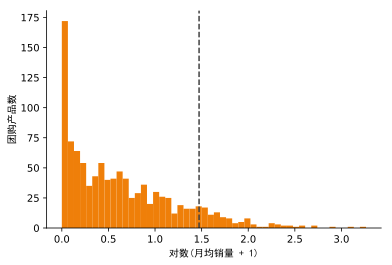

In [286]:
plt.figure()
ax1 = plt.gca()
sns.despine(ax=ax1)
x1 = np.log10(coupon_zzhp['月均销量'].values + 1)
plt.hist(x1,bins=50,color=C['orange'])
plt.axvline(np.log10(minPopMonSales+1),ls='--',c=C['darkblue'])
#plt.axvline(np.log10(maxColdMonSales+1),ls='--',c=C['darkblue'])
plt.xticks(**{'fontname':'WhitneyBook Numeric'})
plt.yticks(**{'fontname':'WhitneyBook Numeric'})
plt.xlabel('对数(月均销量 + 1)')
plt.ylabel('团购产品数')
plt.savefig('res/月均销量图.png',transparent=True,dpi=600)

In [76]:
# 神奇爆款在哪里？
ncoupon_zzhp = len(coupon_zzhp)
coupon_zzhp['销量情况'] = '非爆款'
# 定义产品月均购买人数前10%的团购为爆款
coupon_zzhp.loc[coupon_zzhp['月均销量'].sort_values(ascending=False)[:int(0.1*ncoupon_zzhp)].index,'销量情况'] = '爆款'
# '''
# # 定义产品月均购买人数后25%的团购为冷门
# coupon_zzhp.loc[(coupon_zzhp['月均销量'].sort_values(ascending=False)[int(0.75*ncoupon_zzhp):].index),'销量情况'] = '冷门'
# # 在售时长低于半年的烂款，记为一般，排除销售时间过短的影响
# coupon_zzhp.loc[(coupon_zzhp['销量情况']=='冷门')& (coupon_zzhp['在售时长']<180),'销量情况'] = '一般'
# '''

In [38]:
len(coupon_zzhp[coupon_zzhp['销量情况'] == '爆款'])

103

In [39]:
len(coupon_zzhp[coupon_zzhp['销量情况'] == '非爆款'])

931

In [77]:
coupon_zzhp['折扣率'] = coupon_zzhp['团购价']/coupon_zzhp['市场价']

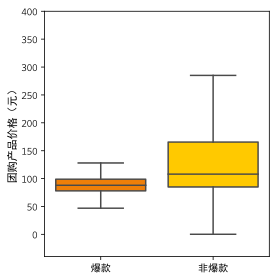

In [42]:
plt.figure(figsize=(4,4))
sns.boxplot(x='销量情况',y='团购价',order=['爆款','非爆款'],
            palette=[C['orange'],C['yellow']],data=coupon_zzhp,
            saturation=1,fliersize=0)
plt.ylim(ymax=400)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('')
plt.ylabel('团购产品价格（元）',fontsize=11)
plt.tight_layout()
plt.savefig('res/爆款非爆款团购产品价格差异.png',transparent=True,dpi=600)

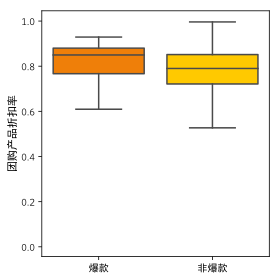

In [317]:
plt.figure(figsize=(4,4))
sns.boxplot(x='销量情况',y='折扣率',order=['爆款','非爆款'],
            palette=[C['orange'],C['yellow']],data=coupon_zzhp,
            saturation=1,fliersize=0)
# plt.ylim(ymin=0.5)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('')
plt.ylabel('团购产品折扣率',fontsize=11)
plt.tight_layout()
plt.savefig('res/爆款非爆款团购产品折扣率差异.png',transparent=True,dpi=600)

In [78]:
coupon_zzhp['餐厅人均'] = None
for index, row in coupon_zzhp.iterrows():
    coupon_zzhp.loc[index,'餐厅人均'] = shops_zzhp[shops_zzhp['店名']==row['店名']]['人均'].values[0]

In [79]:
coupon_zzhp['餐厅人均'] = coupon_zzhp['餐厅人均'].astype(float)

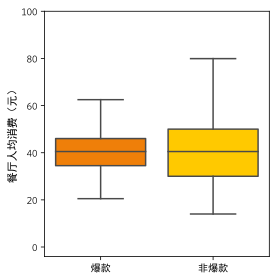

In [318]:
plt.figure(figsize=(4,4))
sns.boxplot(x='销量情况',y='餐厅人均',order=['爆款','非爆款'],
            palette=[C['orange'],C['yellow']],data=coupon_zzhp,
            saturation=1,fliersize=0)
plt.ylim(ymax=100)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('')
plt.ylabel('餐厅人均消费（元）',fontsize=11)
plt.tight_layout()
plt.savefig('res/爆款非爆款团购产品餐厅人均消费差异.png',transparent=True,dpi=600)

In [45]:
shops_zzhp.head(2)

,店名,关键词,城市,评分,评价数,人均,地址,营业时间,菜名
190,李二鲜鱼村,火锅,zz,4.6,3318.0,41.0,郑州市巩义市桐本路与人民路交叉口向北50米路东,11:30-21:00,【芝麻酱】【酸菜鱼】【鸳鸯锅】【鸭血】【瓜子】【酸菜鱼锅】【潮州牛肉丸】【李二豆干】【鱼汤】...
191,岁岁羊火锅(新密店),火锅,zz,4.6,2769.0,51.0,郑州市新密市其他西大街与大鸿路交叉口向东20米路南,暂无时间,【酸梅汤】【海带头】【生菜】【鸳鸯锅】【手切羊肉】【面筋泡】【木耳】【红薯】【牛骨】【鲜鸭肠...


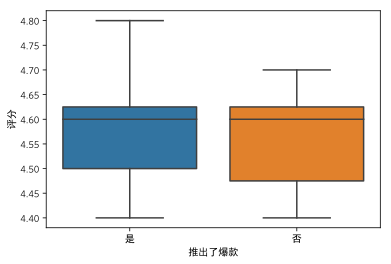

In [970]:
plt.figure()
sns.boxplot(x='推出了爆款',y='评分',data=shops_zzhp[shops_zzhp['评价数']>800])
# plt.ylim(ymax=150)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.show()

In [ ]:
plt.figure()
sns.boxplot(x='销量情况',y='团购评价',data=coupon_zzhp[coupon_zzhp['评价人数']>0])
# plt.ylim(ymax=150)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.show()

## 构造一批服务变量

In [80]:
coupon_zzhp['有免费WiFi'] = '无免费WiFi'
coupon_zzhp['节假日通用'] = '非节假日通用'
coupon_zzhp['免费停车'] = '不提供免费停车'
coupon_zzhp['可使用包间'] = '不可使用包间'
coupon_zzhp['可叠加使用'] = '不可叠加使用'
coupon_zzhp['无需预约'] = '需要预约'
coupon_zzhp['不限张数'] = '限制使用张数'
coupon_zzhp['不限使用人数'] = '限制使用人数'
coupon_zzhp['仅限堂食'] = '可以外带'
for index,row in coupon_zzhp[coupon_zzhp['购买须知'].isnull()==False].iterrows():
    if('免费WiFi' in row['购买须知']):
        coupon_zzhp.loc[index,'有免费WiFi'] = '有免费WiFi'
    if('节假日通用' in row['购买须知']):
        coupon_zzhp.loc[index,'节假日通用'] = '节假日通用'
    if('免费停车' in row['购买须知']):
        coupon_zzhp.loc[index,'免费停车'] = '提供免费停车'
    if(not '仅限大厅使用' in row['购买须知']):
        coupon_zzhp.loc[index,'可使用包间'] = '可使用包间'
    if('可叠加使用' in row['购买须知']):
        coupon_zzhp.loc[index,'可叠加使用'] = '可叠加使用'
    if('无需预约' in row['购买须知']):
        coupon_zzhp.loc[index,'无需预约'] = '无需预约'
    if('不限使用糯米券张数' in row['购买须知']):
        coupon_zzhp.loc[index,'不限张数'] = '不限优惠券使用张数'
    if('不限使用人数' in row['购买须知']):
        coupon_zzhp.loc[index,'不限使用人数'] = '不限使用人数'
    if('仅限堂食' in row['购买须知']):
        coupon_zzhp.loc[index,'仅限堂食'] = '仅限堂食'

In [59]:
from statsmodels.graphics.mosaicplot import mosaic
def DrawServiceMosaic(dfkey=None,title=None):
    plt.figure(figsize=(2,2))
    props = lambda key: {'color': C['orange'] if '爆款' in key else C['yellow']}
    mosaic(coupon_zzhp[['销量情况',dfkey]], index=['销量情况',dfkey],
           labelizer=lambda x:'', properties=props, gap=0.02)
    plt.xticks(fontsize=1)
    plt.tight_layout()
    plt.savefig('res/{0}.png'.format(dfkey), tranparent=True, dpi=600)

In [ ]:
DrawServiceMosaic(dfkey = '有免费WiFi')
DrawServiceMosaic(dfkey = '节假日通用')
DrawServiceMosaic(dfkey = '免费停车')
DrawServiceMosaic(dfkey = '可使用包间')
DrawServiceMosaic(dfkey = '可叠加使用')
DrawServiceMosaic(dfkey = '无需预约') 
DrawServiceMosaic(dfkey = '不限张数')
DrawServiceMosaic(dfkey = '不限使用人数')
DrawServiceMosaic(dfkey = '仅限堂食')

## 营业时长分析
* 正则表达式获取营业起始、结束时间
* pd.Datetime 计算时间差
* 对特殊时间(24:00、全天、暂无）的处理

In [47]:
import re
shops_zzhp['营业时长'] = None
for index,row in shops_zzhp[shops_zzhp['营业时间'].isnull()==False].iterrows():
    if(not row['营业时间']=='暂无时间'):
        if('全天' in row['营业时间']):
             shops_zzhp.loc[index,'营业时长'] = 24
        else:
            # method only take hours in range of 0-23
            tstr = row['营业时间'].replace('24:00','00:00')
            timearr = re.findall(r"(\d{2}:\d{2})",tstr)
            if len(timearr) == 2:
                tlength = (pd.to_datetime(timearr[1]) - pd.to_datetime(timearr[0])).seconds/3600
            if len(timearr) == 4:
                tlength = ((pd.to_datetime(timearr[1]) - pd.to_datetime(timearr[0])).seconds/3600
                          + (pd.to_datetime(timearr[3]) - pd.to_datetime(timearr[2])).seconds/3600)
            if (tlength > 24):
                shops_zzhp.loc[index,'营业时长'] = 0.5 * tlength
            else:
                shops_zzhp.loc[index,'营业时长'] = tlength
       

In [48]:
# Switch to float
shops_zzhp['营业时长'] = shops_zzhp['营业时长'].astype(float)

In [49]:
# impute missing values with mode time length
shops_zzhp.loc[shops_zzhp['营业时长'].isnull(),'营业时长'] = shops_zzhp['营业时长'].mode().values[0]

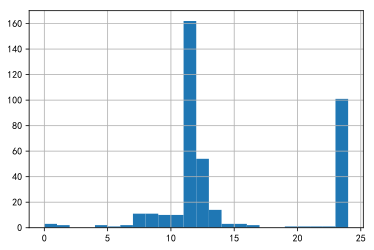

In [65]:
shops_zzhp['营业时长'].hist(bins=24)

In [50]:
shops_zzhp.columns

Index(['店名', '关键词', '城市', '评分', '评价数', '人均', '地址', '营业时间', '菜名', '营业时长'], dtype='object')

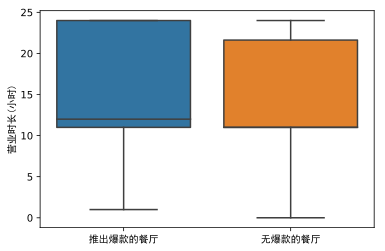

In [430]:
plt.figure()
sns.boxplot(x='推出了爆款',y='营业时长',data=shops_zzhp)
plt.xticks([0,1],['推出爆款的餐厅','无爆款的餐厅'])
plt.yticks(**{'fontname':'WhitneyBook Numeric'})
plt.xlabel('')
plt.ylabel('营业时长(小时)')
plt.show()

## 地址分析：
* 通过[Baidu API](http://lbsyun.baidu.com/)获得经纬度
* 使用folium画图

In [66]:
# Get Geodata from Baidu API
# Ref:
# https://blog.csdn.net/qq_23926575/article/details/72569995
# http://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding
# http://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding-abroad
import json
from urllib.request import urlopen, quote
import requests
def getlatlng(address):
    url = 'http://api.map.baidu.com/geocoder/v2/'
    output = 'json'
    ak = 'xG7oFCEHI3u9u8CVjfiHWHBVNgHbrYsm' # 浏览器端密钥
    address = quote(address[:42]) # up to 84 bytes. 由于本文地址变量为中文，为防止乱码，先用quote进行编码
    uri = url + '?' + 'address=' + address  + '&output=' + output + '&ak=' + ak 
    req = urlopen(uri)
    res = req.read().decode()
    #print(res)
    temp = json.loads(res)
    #print(temp)
    lat = temp['result']['location']['lat']
    lng = temp['result']['location']['lng']
    return lat, lng

def getBusinessRange_byLatLon(lat,lon):
    url = 'http://api.map.baidu.com/geocoder/v2/'
    output = 'json'
    ak = 'xG7oFCEHI3u9u8CVjfiHWHBVNgHbrYsm' # 浏览器端密钥
    uri = url + '?callback=renderReverse' + '&location={0},{1}'.format(lat,lon) + '&output=' + output + '&pois=1&ak=' + ak 
    req = urlopen(uri)
    res = req.read().decode()
    simp_res = res.strip('renderReverse&&renderReverse(')[:-1]
    temp = json.loads(simp_res)
    #print(temp)
    BusinessRange = temp['result']['business']
    return BusinessRange

# def getDist_byLatLon(lat,lon):
#     url = 'http://api.map.baidu.com/geocoder/v2/'
#     output = 'json'
#     ak = 'xG7oFCEHI3u9u8CVjfiHWHBVNgHbrYsm' # 浏览器端密钥
#     uri = url + '?callback=renderReverse' + '&location={0},{1}'.format(lat,lon) + '&output=' + output + '&pois=1&ak=' + ak 
#     req = urlopen(uri)
#     res = req.read().decode()
#     simp_res = res.strip('renderReverse&&renderReverse(')[:-1]
#     temp = json.loads(simp_res)
#     #print(temp)
#     District = temp['result']['addressComponent']['district']
#     return District

In [69]:
shops_zzhp['lon'] = None
shops_zzhp['lat'] = None
for index,row in shops_zzhp.iterrows():
    shops_zzhp.loc[index,'lat'], shops_zzhp.loc[index,'lon'] = getlatlng(row['地址'])

In [73]:
shops_zzhp['商圈'] = None
for index,row in shops_zzhp.iterrows():
    shops_zzhp.loc[index,'商圈'] = getBusinessRange_byLatLon(row['lat'], row['lon'])

In [78]:
shops_zzhp['辖区'] = None
for index,row in shops_zzhp.iterrows():
    shops_zzhp.loc[index,'辖区'] = row['地址'].split('郑州市')[1][:3]

In [96]:
# 对于辖区错误显示为其他的2家商户，经查询其均位于郑州市金水区
shops_zzhp.loc[shops_zzhp['地址'].str.slice(start=3,stop=5)=='其他','辖区'] = '金水区'

In [107]:
distCount = shops_zzhp.groupby('辖区').count()['店名'].sort_values(ascending=False)

In [114]:
distMeanPrice = shops_zzhp.groupby('辖区').mean()['人均'].sort_values(ascending=False)

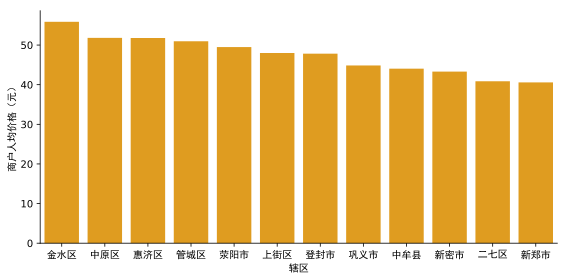

In [431]:
plt.figure(figsize=(8,4))
ax = plt.gca()
sns.despine(ax=ax)
sns.barplot(ax=ax,x=distMeanPrice.index, y=distMeanPrice.values,color='orange')
plt.yticks(**{'fontname':'WhitneyBook Numeric'})
plt.ylabel('商户人均价格（元）')
plt.tight_layout()
plt.savefig('res/各辖区商户人均价格.png',transparent=True,dpi=600)

In [116]:
coupon_zzhp['商圈'] = None
coupon_zzhp['辖区'] = None
for index,row in coupon_zzhp.iterrows():
    coupon_zzhp.loc[index,'商圈'] = shops_zzhp[shops_zzhp['店名']==row['店名']]['商圈'].values[0]
    coupon_zzhp.loc[index,'辖区'] = shops_zzhp[shops_zzhp['店名']==row['店名']]['辖区'].values[0]

In [126]:
popCountByDist = coupon_zzhp[coupon_zzhp['销量情况']=='爆款'].groupby('辖区').count()['团购名']

In [131]:
# 分析商圈饱和度（竞争）、餐厅人均（消费能力）、评价人数（客源）
coupon_zzhp[coupon_zzhp['销量情况']=='爆款'].groupby('辖区').mean()

,团购活动ID,购买人数,团购评价,评价人数,团购价,市场价,月均销量,折扣率,餐厅人均
辖区,,,,,,,,,
上街区,1.29e+07,2632.00,4.56,245.60,78.10,88.80,83.73,0.88,32.80
中原区,1.28e+07,2453.00,4.52,247.83,91.83,112.67,64.58,0.82,41.67
中牟县,4.59e+06,1794.50,4.55,156.50,88.00,100.00,50.88,0.88,46.50
二七区,1.25e+07,6859.00,4.50,539.00,38.80,49.00,252.14,0.79,40.00
巩义市,1.42e+07,3082.04,4.09,368.72,99.51,123.93,177.85,0.82,39.82
惠济区,7.42e+06,2063.33,4.43,287.33,128.67,171.80,63.55,0.76,46.33
新密市,2.52e+07,3361.93,4.30,291.33,86.53,112.07,114.39,0.78,40.59
新郑市,2.13e+07,2783.38,4.45,222.92,113.66,142.03,120.82,0.81,41.50
登封市,3.19e+07,4764.47,4.45,185.29,96.42,112.88,196.85,0.85,46.56


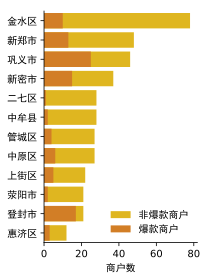

In [449]:
plt.figure(figsize=(3,4))
ax = plt.gca()
sns.despine(ax=ax)
sns.barplot(ax=ax,y=distCount.index, x=distCount.values,
            color=C['yellow'], label='非爆款商户', 
            orient='h')
sns.barplot(ax=ax,y=popCountByDist.index, x=popCountByDist.values,
            order=distCount.index.values,color=C['orange'], label='爆款商户', 
            orient='h')
plt.xticks(**{'fontname':'WhitneyBook Numeric'})
plt.xlabel('商户数')
plt.ylabel('')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('res/各辖区爆款非爆款商户数统计.png',transparent=True,dpi=600)

In [435]:
coupon_zzhp.columns

Index(['团购名', '店名', '团购活动ID', '团购介绍', '购买人数', '团购评价', '评价人数', '到期时间', '团购价',
       '市场价', '地址', '团购内容', '备注', '购买须知', '起售日', '在售时长', '月均销量', '销量情况', '折扣率',
       '餐厅人均', '有免费WiFi', '节假日通用', '免费停车', '可使用包间', '可叠加使用', '无需预约', '不限张数',
       '不限使用人数', '仅限堂食', '商圈', '辖区'],
      dtype='object')

In [436]:
# 累积各店团购产品销售量
flow_byShop = coupon_zzhp.groupby('店名').sum()['月均销量']

In [437]:
# 从shops_zzhp表中用商户名提取出经纬度；与商户购买人数数据合并，构造购买量热图数据
shop_names = flow_byShop.index.values
lat = [(shops_zzhp.loc[shops_zzhp['店名']==sname,'lat'].values[0]) for sname in shop_names]
lon = [(shops_zzhp.loc[shops_zzhp['店名']==sname,'lon'].values[0]) for sname in shop_names]
heatmap_data = [[lat[i],lon[i],flow_byShop[sname]] for i,sname in enumerate(shop_names)] 

In [441]:
# 使用folium包，对数据中商户购买量进行可视化（热图）
import folium
from folium.plugins import HeatMap
# location: center of map; zoom_start: zoom level when start
map_osm = folium.Map(location=[34.6916,113.5168],zoom_start=10)
# Draw HeatMap
HeatMap(heatmap_data,min_opacity=0.2,radius=10).add_to(map_osm)
# Show map
map_osm

## 热门爆款商圈 wordcloud

In [454]:
bizName = {}
for index,row in coupon_zzhp.iterrows():
    biznm = row['商圈'].strip()
    if(len(biznm)>0):
        for ibiz in biznm.split(','):
            bizName[ibiz]=1

In [457]:
len(bizName)

105

In [217]:
# 突出月均销量高的商圈
hotBizName = ','.join((coupon_zzhp['月均销量']*365).astype(int)*(coupon_zzhp['商圈']+','))

In [213]:
# 读入火锅图片蒙版
from scipy.misc import imread
hotpotmask = imread('data/bighotpot3.png')

In [ ]:
# 热门商圈词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = hotpotmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(hotBizName.lower())
plt.axis("off")
#plt.show()
wc.to_file('hotbiz.png')

## 菜名分析(爆款与否)
* 名字词云
* 丰富度（长度）
* 特色度（低频菜数量）

In [227]:
shops_zzhp['推出了爆款'] = '否'
for index,row in shops_zzhp.iterrows():
    if('爆款' in coupon_zzhp.loc[coupon_zzhp['店名']==row['店名'],'销量情况'].values):
        shops_zzhp.loc[index,'推出了爆款'] = '是'

In [469]:
nonPopDishNames = '.'.join(shops_zzhp.loc[(shops_zzhp['推出了爆款']=='否')&(shops_zzhp['菜名']!='暂无菜品'),'菜名'].str.strip('【').str.replace('】【',',').str.replace('】',''))

In [470]:
PopDishNames = '.'.join(shops_zzhp.loc[(shops_zzhp['推出了爆款']=='是')&(shops_zzhp['菜名']!='暂无菜品'),'菜名'].str.strip('【').str.replace('】【',',').str.replace('】',''))

In [ ]:
# 爆款菜名词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = hotpotmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(PopDishNames.lower())
plt.axis("off")
#plt.show()
wc.to_file('res/PopDishNames.png')

In [ ]:
# 非爆款菜名词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=5, background_color = 'white',
               mask = hotpotmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(nonPopDishNames.lower())
plt.axis("off")
#plt.show()
wc.to_file('res/nonPopDishNames.png')

In [242]:
shops_zzhp['菜品个数'] = shops_zzhp['菜名'].str.split('【').str.len()-1

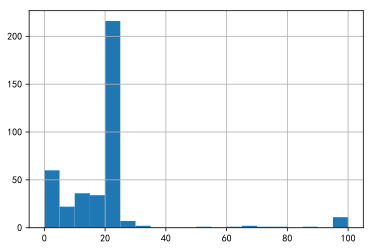

In [252]:
shops_zzhp['菜品个数'].hist(bins=20)

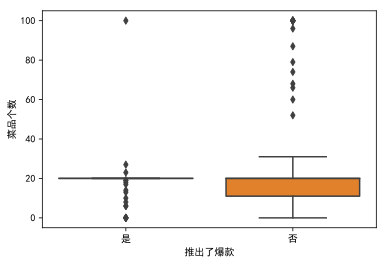

In [256]:
plt.figure()
sns.boxplot(x='推出了爆款',y='菜品个数',data=shops_zzhp)
plt.show()

## 商圈/辖区筛选
* 商圈饱和程度（竞争：绝对数量与爆款比例）
* 餐厅平均人均（消费能力）
* 购买人数（客源）

## 评价文字处理
* 评分分析
* 好评/差评 关键词
* or 爆款-非爆款 关键词

In [995]:
comments_zzhp['团购为爆款'] = 0
for index,row in comments_zzhp.iterrows():
        comments_zzhp.loc[index,'团购为爆款'] = coupon_zzhp.loc[coupon_zzhp['团购活动ID']==row['团购活动ID'],'销量情况'].values[0]

In [1005]:
comments_zzhp[comments_zzhp['团购为爆款']==0]['评分'].describe()

count    14327.00
mean         4.52
std          0.97
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: 评分, dtype: float64

In [1006]:
comments_zzhp[comments_zzhp['团购为爆款']==1]['评分'].describe()

count    24240.00
mean         4.57
std          0.91
min          1.00
25%          5.00
50%          5.00
75%          5.00
max          5.00
Name: 评分, dtype: float64

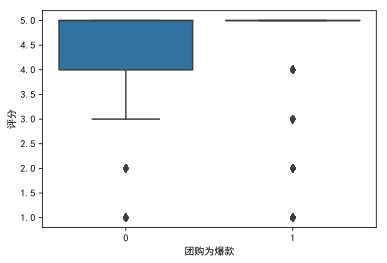

In [1002]:
plt.figure()
sns.boxplot(x = '团购为爆款',y ='评分',data = comments_zzhp)
plt.show()

In [1012]:
# HighRateCmts = ';'.join(comments_zzhp[(comments_zzhp['评价内容'].notnull())&(comments_zzhp['评分']>=4)]['评价内容'])

In [1013]:
# LowRateCmts = ';'.join(comments_zzhp[(comments_zzhp['评价内容'].notnull())&(comments_zzhp['评分']<4)]['评价内容'])

In [1054]:
HighRateCmts = ';'.join(comments_zzhp[(comments_zzhp['评价内容'].notnull())&(comments_zzhp['评价感情倾向']>=0.8)]['评价内容'])

In [1098]:
LowRateCmts = ';'.join(comments_zzhp[(comments_zzhp['评价内容'].notnull())&(comments_zzhp['评价感情倾向']<=0.5)]['评价内容'])

In [1027]:
# 去掉Stopwords
with open('data/CNstopwords.txt',encoding='utf-8') as f:
    stopWords = [line.strip() for line in f.readlines()]

In [1097]:
SnowNLP('').sentiments

0.291537140004429

In [1056]:
HighRateDict = {}
for word in jieba.cut(HighRateCmts):
    if((word not in ' ,./!?;:，。、！？；：‘’') and (word not in stopWords)):
        if(HighRateDict.get(word) is None):
            HighRateDict[word] = 1
        else:
            HighRateDict[word] += 1    

In [1099]:
LowRateDict = {}
for word in jieba.cut(LowRateCmts):
    if((word not in ' ,./!?;:，。、！？；：‘’') and (word not in stopWords)):
        if(LowRateDict.get(word) is None):
            LowRateDict[word] = 1
        else:
            LowRateDict[word] += 1    

In [1058]:
# pop nonbreaking space '\xa0'
HighRateDict.pop('\xa0')

439

In [1104]:
# pop nonbreaking space '\xa0'
LowRateDict.pop('\xa0')

1545

In [1247]:
# 读入图片蒙版
from scipy.misc import imread
headmask = imread('data/speak.png')

In [1060]:
HighRateCmtWords = ''
for word,nhit in HighRateDict.items():
    HighRateCmtWords = HighRateCmtWords + (word+',') * nhit 

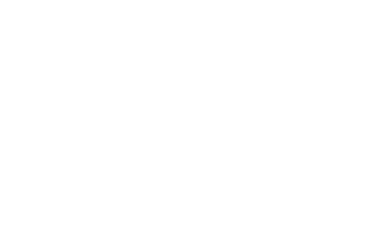

In [1248]:
# 好评评论短语词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = headmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(HighRateCmtWords.lower())
plt.axis("off")
#plt.show()
wc.to_file('感情倾向积极短语词云.png')

In [1110]:
LowRateCmtWords = ''
for word,nhit in LowRateDict.items():
    LowRateCmtWords = LowRateCmtWords + (word+',') * nhit 

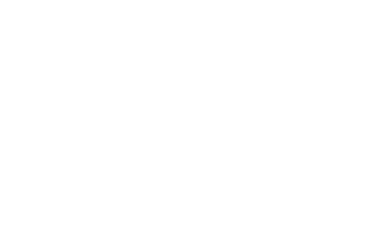

In [1254]:
# 差评评论短语词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'bone', 
               min_font_size=8, background_color = 'white',
               mask = headmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(LowRateCmtWords.lower())
plt.axis("off")
#plt.show()
wc.to_file('感情倾向消极短语词云.png')

### 评价感情色彩分析

In [698]:
from snownlp import SnowNLP

In [980]:
# 评论感情色彩分析
txt2 = comments_zzhp['评价内容'].iloc[10000]
print(txt2)
s2 = SnowNLP(txt2)
print('{:.3f}'.format(s2.sentiments))

可以就是送的菜好少啊，生菜就几片，味道还是不错的！
0.780


In [829]:
comments_zzhp['评价感情倾向'] = None
for index,row in comments_zzhp[comments_zzhp['评价内容'].isnull()==False].iterrows():
    comments_zzhp.loc[index,'评价感情倾向'] = SnowNLP(row['评价内容']).sentiments

In [850]:
sens = comments_zzhp['评价感情倾向'].dropna()

### 好评/差评中提及的菜品
* 好评/差评：>=4分/<4分
* 菜品：提取菜品字典，并针对每条评论分词、检索出现的菜品，计数

In [763]:
# 构建菜品字典
fullword = ','.join(shops_zzhp.loc[(shops_zzhp['菜名']!='暂无菜品'),'菜名'].str.strip('【').str.replace('】【',',').str.replace('】',''))
fullwordList = fullword.split(',')
dishSet = set(fullwordList)

In [818]:
# 去除数据中错误分词
dishSet.remove('火锅')
dishSet.remove('人套餐')
dishSet.remove('美味')

In [819]:
# 输出菜品字典
dishes = '\n'.join(list(dishSet))
with open('data/dishDict.txt','w',encoding='utf-8') as f:
    f.write(dishes)

In [921]:
import jieba
jieba.load_userdict('data/dishDict.txt')

In [702]:
comments_zzhp['评价内容'].iloc[0]

'这家店竟然没有玉米饼和杠子馍。。'

In [767]:
jieba.lcut(txt1)

['这家', '店', '竟然', '没有', '玉米饼', '和', '杠子', '馍', '。', '。']

In [821]:
HitDishDict = {}
for i in comments_zzhp[comments_zzhp['评价内容'].isnull()==False].index:
    cutList = jieba.lcut(comments_zzhp.loc[i,'评价内容'])
    for icut in cutList:
        if(icut in dishSet):
            if(HitDishDict.get(icut) is None):
                HitDishDict[icut] = 1
            else:
                HitDishDict[icut] += 1

In [822]:
HitDishWords = ''
for dishnm,nhit in HitDishDict.items():
    HitDishWords = HitDishWords + (dishnm+',') * nhit 

In [1245]:
# 读入图片蒙版
from scipy.misc import imread
comtmask = imread('data/comments.png')

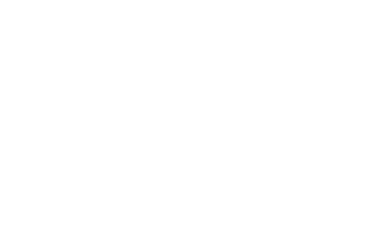

In [1246]:
# 评论提及的菜词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = comtmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(HitDishWords.lower())
plt.axis("off")
#plt.show()
wc.to_file('评论提及的菜名词云.png')

In [833]:
# 通过评分看好评评价中提及的高频菜（评分>=4）
PopDishDict = {}
for i in comments_zzhp[(comments_zzhp['评分']>=4)&(comments_zzhp['评价内容'].isnull()==False)].index:
    cutList = jieba.lcut(comments_zzhp.loc[i,'评价内容'])
    for icut in cutList:
        if(icut in dishSet):
            if(PopDishDict.get(icut) is None):
                PopDishDict[icut] = 1
            else:
                PopDishDict[icut] += 1

In [834]:
PopDishWords = ''
for dishnm,nhit in PopDishDict.items():
    PopDishWords = PopDishWords + (dishnm+',') * nhit 

In [846]:
# 读入火锅图片蒙版
from scipy.misc import imread
thumbmask = imread('data/thumb2.png')

In [ ]:
# 4分好评菜品词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = thumbmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(PopDishWords.lower())
plt.axis("off")
#plt.show()
wc.to_file('4分及以上好评评论提及的菜名词云.png')

#### 爆款/非爆款菜品词云（取形容词词性失败）

In [931]:
# 通过评分统计爆款的评价中提及的菜名
HotDishDict = {}
for i in comments_zzhp[(comments_zzhp['团购为爆款']==1)&(comments_zzhp['评价内容'].isnull()==False)].index:
    cutList = jieba.lcut(comments_zzhp.loc[i,'评价内容'])
    for icut in cutList:
        if(icut in dishSet):
            if(HotDishDict.get(icut) is None):
                HotDishDict[icut] = 1
            else:
                HotDishDict[icut] += 1

In [945]:
# 通过评分统计【非】爆款的评价中提及的菜名
nonHotDishDict = {}
for i in comments_zzhp[(comments_zzhp['团购为爆款']==0)&(comments_zzhp['评价内容'].isnull()==False)].index:
    cutList = jieba.lcut(comments_zzhp.loc[i,'评价内容'])
    for icut in cutList:
        if(icut in dishSet):
            if(nonHotDishDict.get(icut) is None):
                nonHotDishDict[icut] = 1
            else:
                nonHotDishDict[icut] += 1

In [946]:
nonHotDishWords = ''
for dishnm,nhit in nonHotDishDict.items():
    nonHotDishWords = nonHotDishWords + (dishnm+',') * nhit 

In [933]:
# 读入大拇指图片蒙版
from scipy.misc import imread
thumbmask = imread('data/thumb2.png')

In [ ]:
# 爆款菜名词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = thumbmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(HotDishWords.lower())
plt.axis("off")
#plt.show()
wc.to_file('爆款评论提及的菜名词云.png')

In [ ]:
# 【非】爆款菜名词云
from wordcloud import WordCloud
font = r'C:\Windows\Fonts\simhei.ttf'
wc = WordCloud(collocations=False, colormap= 'autumn', 
               min_font_size=8, background_color = 'white',
               mask = thumbmask,font_path=font, width=3500, 
               height=2000, margin=50, 
               stopwords=[',',' ']).generate(nonHotDishWords.lower())
plt.axis("off")
#plt.show()
wc.to_file('非爆款评论提及的菜名词云.png')

In [ ]:
# 爆款评论中出现的菜品中的形容词
# import importlib
# importlib.reload(jieba)
# import jieba.posseg as pseg

# sepHotDishWords = [list(pseg.cut(word))[0] for word in jieba.cut(HotDishWords)]

# decWordType = ['Ag','a','ad','an', # adjectives
#                'Dg','d','s','vd','vn','z'] # adverbs, location, verb(using as ad/n), cond
# decWordDict = {}
# for word, wordtype in sepHotDishWords:
#     if(wordtype in decWordType):
#         if(decWordDict.get(word) is None):
#             decWordDict[word] = 1
#         else:
#             decWordDict[word] += 1
# decWordDict

## 商户购买量/评分 受 季节的影响

In [480]:
# 季节影响
comments_zzhp.groupby('消费门店').count()['团购活动ID'].sort_values(ascending=False).head(2)

消费门店
李想大虾(巩义店)    2870
李二鲜鱼村        2230
Name: 团购活动ID, dtype: int64

In [178]:
coupon_zzhp['地址'].head(2)

485           郑州市金水区东风路与东明路交叉口向南50米路东三楼
486    郑州市新密市溱水路与大鸿路交叉口向南50米路西（大鸿路332号）
Name: 地址, dtype: object

In [179]:
comments_zzhp.count()

团购活动ID    39146
用户ID      39146
用户名       39146
评价时间      39146
评价内容      28528
评分        39146
消费门店      39146
用户排名      39146
dtype: int64

## 团购产品图片分析
* 主色调
* 颜色分散/突出程度（留白程度）
* 对比度、亮度

In [1229]:
'''
链接：https://www.zhihu.com/question/29268904/answer/44402669
'''

# USAGE
# python color_kmeans.py --image images/jp.png --clusters 3
# Author: Adrian Rosebrock
# Website: www.pyimagesearch.com

# import the necessary packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2

def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

def rgb2hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

def array_rgb2hsv(rgbarray):
    narr = rgbarray.shape[0]
    retarr = np.zeros_like(rgbarray)
    for iarr in range(narr):
        h,s,v = rgb2hsv(rgbarray[iarr,0], 
                        rgbarray[iarr,1],
                        rgbarray[iarr,2])
        retarr[iarr,0] = h
        retarr[iarr,1] = s
        retarr[iarr,2] = v
    return retarr

def hsv2chn(hsvarr):
    hue = int(hsvarr[0])
    sat = hsvarr[1]
    bright = hsvarr[2]
    if(bright < 0.2):
        return '黑'
    elif(sat < 0.2 and bright > 0.8):
        return '白'
    if(hue in list(range(0,26))+list(range(321,361))):
        return '红'
    if(hue in list(range(26,31))):
        return '橙'
    if(hue in list(range(31,61))):
        return '黄'
    if(hue in list(range(61,131))):
        return '绿'
    if(hue in list(range(131,171))):
        return '青'
    if(hue in list(range(171,251))):
        return '蓝'
    if(hue in list(range(251,321))):
        return '紫'

def hsvs2chn(hsvs):
    hsvnm = []
    for hsv in hsvs:
        #print(hsv)
        hsvnm.append(hsv2chn(hsv))
    return hsvnm

def imgRecog(imgPath):
    '''
    输入图像，返回：
    1. 图像三主色（可能同色）；
    2. 主色比例（同色将会合并）；
    3. 图像饱和度；
    4. 图像亮度
    '''
    # load the image and convert it from BGR to RGB so that
    # we can display it with matplotlib
    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # # show our image
    # plt.figure()
    # plt.axis("off")
    # plt.imshow(image)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = 3)
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)
    image_hsv = array_rgb2hsv(clt.cluster_centers_)
    # output
    color_chn = np.array(hsvs2chn(image_hsv))
    main_color_ratio = sum(hist[color_chn==color_chn[np.argmax(hist)]])
    image_sat = sum(image_hsv[:,1]*hist)
    image_bri = sum(image_hsv[:,2]*hist)
    # image output
    #bar = plot_colors(hist, clt.cluster_centers_)
    # # show our color bar
    # plt.figure()
    # plt.axis("off")
    # plt.imshow(bar)
    # plt.show()
    
    return color_chn, main_color_ratio, image_sat, image_bri


In [1451]:
# 加载在外面算好的图片信息
picRecog = pd.read_csv('zzhp_pic_recog.csv',index_col=0,header=0)

In [1455]:
picRecog['是否爆款'] = 0
for index,row in picRecog.iterrows():
    picRecog.loc[index,'是否爆款'] = coupon_zzhp.loc[coupon_zzhp['团购活动ID']==row['所属团购ID'],'销量情况'].values[0]

In [1458]:
popPicDf = picRecog[picRecog['是否爆款']==1]
nonpopPicDf = picRecog[picRecog['是否爆款']==0]

In [1467]:
popMainColor = sorted(''.join(popPicDf['图片主色']))
nonpopMainColor = sorted(''.join(nonpopPicDf['图片主色']))

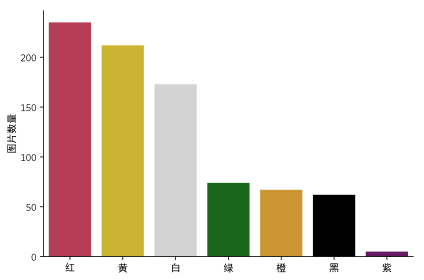

In [1529]:
plt.figure()
sns.despine(ax=plt.gca())
sns.countplot(x=popMainColor,order=['红','黄','白','绿','橙','黑','紫'],
              palette = ['crimson','gold','lightgrey','green','orange','k','purple'],
              saturation = 0.6)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.ylabel('图片数量')
plt.tight_layout()
plt.savefig('res/爆款包含主色的图片数量.png',transparent=True,dpi=600)

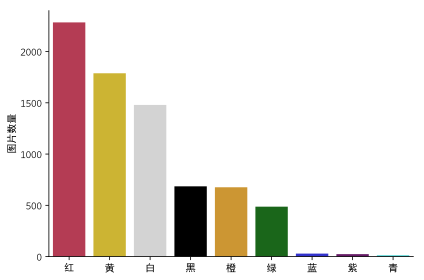

In [1528]:
plt.figure()
sns.despine(ax=plt.gca())
sns.countplot(x = nonpopMainColor, order = ['红','黄','白','黑','橙','绿','蓝','紫','青'],
               palette = ['crimson','gold','lightgrey','k','orange','green','blue','purple','cyan'],
               saturation = 0.6)
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.ylabel('图片数量')
plt.tight_layout()
plt.savefig('res/非爆款包含主色的图片数量.png',transparent=True,dpi=600)

In [1539]:
popPicDf

,所属团购ID,图片主色,图片主色比例,图片饱和度,图片亮度,是否爆款
49,4734380,红黄黄,0.73,0.72,0.67,1
50,4734380,红白黄,0.40,0.50,0.62,1
51,4734380,黑白黄,0.42,0.16,0.50,1
52,4729634,白红黑,0.52,0.26,0.67,1
53,4729634,红白黑,0.43,0.27,0.57,1
54,4729634,红黑白,0.46,0.26,0.60,1
55,12460138,红红红,1.00,0.64,0.76,1
56,12460138,红红红,1.00,0.53,0.79,1
57,12460138,红黄黑,0.44,0.41,0.63,1
104,36427146,橙黄红,0.46,0.71,0.63,1


In [1501]:
# 主色集中度/饱和度/亮度 histogram/均值 爆款/非爆款比较
popPicDf.describe()

,所属团购ID,图片主色比例,图片饱和度,图片亮度,是否爆款
count,2.76e+02,276.00,276.00,276.00,276.0
mean,1.82e+07,0.58,0.43,0.64,1.0
std,1.55e+07,0.18,0.18,0.12,0.0
min,3.16e+05,0.34,0.08,0.31,1.0
25%,4.35e+06,0.43,0.27,0.55,1.0
50%,8.03e+06,0.53,0.45,0.64,1.0
75%,3.64e+07,0.72,0.57,0.72,1.0
max,4.12e+07,1.00,0.83,0.94,1.0


In [1502]:
nonpopPicDf.describe()

,所属团购ID,图片主色比例,图片饱和度,图片亮度,是否爆款
count,2.49e+03,2488.00,2488.00,2488.00,2488.0
mean,2.68e+07,0.57,0.42,0.62,0.0
std,1.47e+07,0.18,0.17,0.13,0.0
min,8.82e+05,0.34,0.03,0.21,0.0
25%,8.70e+06,0.43,0.30,0.53,0.0
50%,3.57e+07,0.52,0.42,0.63,0.0
75%,3.87e+07,0.70,0.54,0.71,0.0
max,4.17e+07,1.00,0.90,0.92,0.0


In [1519]:
popRatio = (popPicDf['图片主色比例'].values*100)#.astype(int)
nonpopRatio = (nonpopPicDf['图片主色比例'].values*100)#.astype(int)

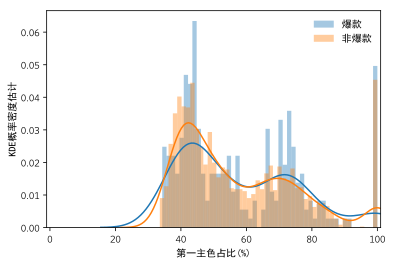

In [1531]:
plt.figure()
sns.distplot(popRatio,bins=50,label='爆款')
sns.distplot(nonpopRatio,bins=50,label='非爆款')
plt.legend(frameon=False)
plt.xlim(-1,101)
plt.xticks(**{'fontname':'WhitneyNumeric Book'})
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('第一主色占比(%)')
plt.ylabel('KDE概率密度估计')
plt.show()

In [1522]:
popSatRatio = (popPicDf['图片饱和度'].values*100)#.astype(int)
nonpopSatRatio = (nonpopPicDf['图片饱和度'].values*100)#.astype(int)

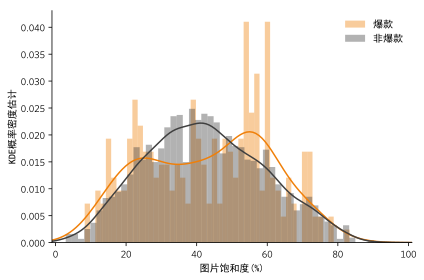

In [1538]:
plt.figure()
sns.despine(ax=plt.gca())
sns.distplot(popSatRatio,bins=50,label='爆款',color=C['orange'])
sns.distplot(nonpopSatRatio,bins=50,label='非爆款',color=C['darkblue'])
plt.legend(frameon=False)
plt.xlim(-1,101)
plt.xticks(**{'fontname':'WhitneyNumeric Book'})
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('图片饱和度(%)')
plt.ylabel('KDE概率密度估计')
plt.tight_layout()
plt.savefig('res/爆款非爆款图片饱和度.png',transparent=0,dpi=600)

In [1526]:
popBriRatio = (popPicDf['图片亮度'].values*100)#.astype(int)
nonpopBriRatio = (nonpopPicDf['图片亮度'].values*100)#.astype(int)

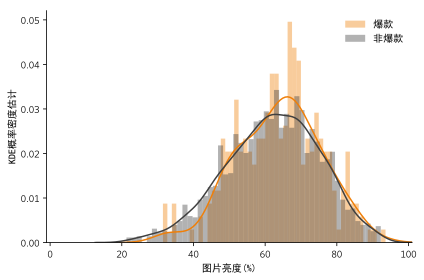

In [1542]:
plt.figure()
sns.despine(ax=plt.gca())
sns.distplot(popBriRatio,bins=50,label='爆款',color=C['orange'])
sns.distplot(nonpopBriRatio,bins=50,label='非爆款',color=C['darkblue'])
plt.legend(frameon=False)
plt.xlim(-1,101)
plt.xticks(**{'fontname':'WhitneyNumeric Book'})
plt.yticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('图片亮度(%)')
plt.ylabel('KDE概率密度估计')
plt.tight_layout()
plt.savefig('res/爆款非爆款图片亮度.png',transparent=0,dpi=600)

### 统计图片数量，作为建模feature

In [1239]:
import glob

In [1267]:
coupon_zzhp['图片数量'] = None

In [1273]:
for ind in coupon_zzhp.index.values:
    coupon_zzhp.loc[ind,'图片数量'] = len(glob.glob('data/pics/{0}*'.format(coupon_zzhp.loc[ind,'团购活动ID'])))

In [1276]:
coupon_zzhp['图片数量'] = coupon_zzhp['图片数量'].astype(int)

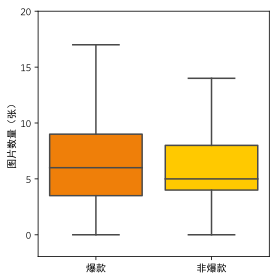

In [1503]:
plt.figure(figsize=(4,4))
sns.boxplot(x='销量情况',y='图片数量',data=coupon_zzhp,
            order=[1,0],palette=[C['orange'],C['yellow']],fliersize=0,
            saturation = 1)
plt.ylim(ymax=20)
plt.yticks(np.arange(0,21,5),np.arange(0,21,5),**{'fontname':'WhitneyNumeric Book'})
plt.xticks([0,1],['爆款','非爆款'])
plt.ylabel('图片数量（张）')
plt.xlabel('')
plt.tight_layout()
plt.savefig('res/图片数量与爆款关系.png',transparent = True, dpi=600)

## 优惠券卖的好还是商品团购卖的好？

In [83]:
coupon_zzhp['团购商品种类'] = coupon_zzhp['团购名'].str.contains('代金券').astype(int)
coupon_zzhp.loc[coupon_zzhp['团购商品种类'] == 0,'团购商品种类'] = '餐食团购'
coupon_zzhp.loc[coupon_zzhp['团购商品种类'] == 1,'团购商品种类'] = '代金券团购'

<Figure size 144x144 with 0 Axes>

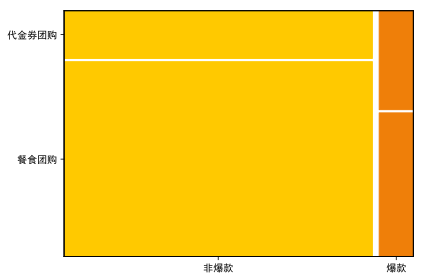

In [84]:
DrawServiceMosaic(dfkey='团购商品种类')

## 建模：爆款-非爆款的影响因素
* 逻辑回归

In [1288]:
coupon_zzhp.columns

Index(['团购名', '店名', '团购活动ID', '团购介绍', '购买人数', '团购评价', '评价人数', '到期时间', '团购价',
       '市场价', '地址', '团购内容', '备注', '购买须知', '起售日', '在售时长', '月均销量', '销量情况', '折扣率',
       '餐厅人均', '有免费WiFi', '节假日通用', '免费停车', '可使用包间', '可叠加使用', '无需预约', '不限张数',
       '不限使用人数', '仅限堂食', '商圈', '辖区', '餐厅营业时长', '餐厅评分', '图片数量'],
      dtype='object')

In [511]:
coupon_zzhp['餐厅营业时长'] = 0
for index,row in coupon_zzhp.iterrows():
    coupon_zzhp.loc[index,'餐厅营业时长'] = shops_zzhp.loc[shops_zzhp['店名']==row['店名'],'营业时长'].values[0]

In [516]:
coupon_zzhp['餐厅评分'] = 0
for index,row in coupon_zzhp.iterrows():
    coupon_zzhp.loc[index,'餐厅评分'] = shops_zzhp.loc[shops_zzhp['店名']==row['店名'],'评分'].values[0]

In [1289]:
y = coupon_zzhp['销量情况']

In [1290]:
y.loc[y=='爆款'] = 1
y.loc[y=='非爆款'] = 0

In [1305]:
y = y.astype(int)

In [1293]:
X_preOHE = coupon_zzhp[['购买人数', '团购评价', '评价人数', '团购价', '市场价',
                       '在售时长', '月均销量',  '折扣率', '餐厅人均', '有免费WiFi', 
                       '节假日通用', '免费停车', '可使用包间', '可叠加使用', 
                       '无需预约', '不限张数','不限使用人数', '仅限堂食', '辖区',
                        '餐厅营业时长', '餐厅评分', '图片数量']]

In [1294]:
X = pd.get_dummies(X_preOHE,columns=['有免费WiFi', '节假日通用', '免费停车', '可使用包间', '可叠加使用', 
                                     '无需预约', '不限张数','不限使用人数', '仅限堂食', '辖区'])

In [1295]:
X.columns

Index(['购买人数', '团购评价', '评价人数', '团购价', '市场价', '在售时长', '月均销量', '折扣率', '餐厅人均',
       '餐厅营业时长', '餐厅评分', '图片数量', '有免费WiFi_无免费WiFi', '有免费WiFi_有免费WiFi',
       '节假日通用_节假日通用', '节假日通用_非节假日通用', '免费停车_不提供免费停车', '免费停车_提供免费停车',
       '可使用包间_不可使用包间', '可使用包间_可使用包间', '可叠加使用_不可叠加使用', '可叠加使用_可叠加使用',
       '无需预约_无需预约', '无需预约_需要预约', '不限张数_不限优惠券使用张数', '不限张数_限制使用张数',
       '不限使用人数_不限使用人数', '不限使用人数_限制使用人数', '仅限堂食_仅限堂食', '仅限堂食_可以外带', '辖区_上街区',
       '辖区_中原区', '辖区_中牟县', '辖区_二七区', '辖区_巩义市', '辖区_惠济区', '辖区_新密市', '辖区_新郑市',
       '辖区_登封市', '辖区_管城区', '辖区_荥阳市', '辖区_金水区'],
      dtype='object')

In [1296]:
X.columns = ['购买人数', '团购评价', '评价人数', '团购价', '市场价', '在售时长', '月均销量', '折扣率', '餐厅人均',
             '餐厅营业时长', '餐厅评分', '图片数量',
             '无免费WiFi', '有免费WiFi', '节假日通用', '非节假日通用', '不提供免费停车', '提供免费停车', '不可使用包间', '可使用包间',
             '不可叠加使用', '可叠加使用', '无需预约', '需要预约', '不限优惠券使用张数', '限制使用张数', '不限使用人数', '限制使用人数',
             '仅限堂食', '可以外带', '辖区_上街区', '辖区_中原区', '辖区_中牟县', '辖区_二七区', '辖区_巩义市', '辖区_惠济区', '辖区_新密市', 
             '辖区_新郑市', '辖区_登封市', '辖区_管城区', '辖区_荥阳市',  '辖区_金水区']

In [1297]:
X['在售时长'] = X['在售时长'].astype(float)

In [1298]:
X_rm = X.drop(['月均销量','购买人数','评价人数'],axis=1)

### Statsmodels method

In [1299]:
# 使用statsmodels package
import statsmodels.api as sm
# 导入formula api可以使statsmodel支持R-like回归语法
import statsmodels.formula.api as smf

In [1300]:
# python中没有简单的forward/backward selection函数
# 此处新建立了一个backward selection函数
# 参考 https://planspace.org/20150423-forward_selection_with_statsmodels/
# 增加log-transform功能
def backward_selected(data, response, maxiter=10, logtrans=None):
    """
    Linear model designed by **backward** selection.

    Parameters:
    -----------
    data     : (pandas DataFrame)
               with all possible predictors and response
    response : (string)
               name of response column in data
    logtrans : (string / list of string)
               predictors need to be log-transformed

    Returns:
    --------
    model    : an "optimal" fitted statsmodels linear model
               selected by forward selection
               evaluated by BIC
    """
    # 获取特征名List
    dataColumns = list(data.columns)
    # logtrans列表的变量（包括因变量）添加log用于之后回归的公式
    if(logtrans is not None):
        for i,istr in enumerate(dataColumns):
            if(istr in logtrans):
                dataColumns[i] = 'np.log({0})'.format(istr)
    # 设定逐步回归留下/舍弃的变量集合与列表
    remaining = set(dataColumns)
    remaining.remove(response)
    selected = list(remaining)
    # BIC越低越好，初始值定为一个高值
    current_score, best_score = 1e9, 1e9
    # 进行迭代，迭代停止条件：BIC不再减少，或舍弃全部变量
    niter = 0
    while (niter< maxiter) and remaining and (current_score == best_score):
        niter += 1 
        # 新建/清空（BIC分数，舍弃变量）元组列表
        scores_with_candidates = []
        for candidate in remaining:
            # 按顺序尝试舍弃仍没被舍弃的变量
            sel = remaining.copy()
            sel.remove(candidate)
            sel_list = list(sel)
            # 建立尝试舍弃candidate变量的模型
            formula = "{} ~ {}".format(response,' + '.join(sel_list))
            # score记为本次模型的BIC
            score = smf.logit(formula, data).fit(maxiter=1000,full_output=0,disp=0).bic
            # 记录舍弃的变量和相应的BIC
            scores_with_candidates.append((score, candidate))
        # 对记录的（分数，变量）元组列表按分数由低至高进行排序
        scores_with_candidates.sort(reverse=True)
        # 选择BIC分数最高的变量（并将其出栈-移出列表）
        current_score, current_candidate = scores_with_candidates.pop()
        # 如果当前模型BIC表现优于（即低于）历史最佳模型BIC
        if current_score < best_score:
            # 从变量列表中移除本次移除的变量
            remaining.remove(current_candidate)
            # 打印移除变量提示及历史最佳/当前BIC
            print('REMOVED: \'{0}\'. Prev Score: {1:.2f}. Currently {2:.2f}'
                  .format(current_candidate, best_score, current_score))
            # 更新历史最佳BIC
            best_score = current_score
    # 打印选择后的特征变量
    selected = list(remaining)
    print('=========================================')
    print('SELECTED FEATURES:',selected)
    # 根据选择后的特征建立回归公式
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    # 利用statsmodel的logistic回归
    #model = smf.logit(formula, data).fit(maxiter=1000)
    model = smf.logit(formula, data).fit_regularized(maxiter=1000,alpha=1)
    # 返回选择后的优选模型
    return model

In [1306]:
X_sm = pd.concat([X_rm,y],axis=1)

In [1309]:
smlr_best = backward_selected(X_sm,'销量情况',maxiter=20,logtrans=None)

REMOVED: '折扣率'. Prev Score: 1000000000.00. Currently 698.39
REMOVED: '餐厅人均'. Prev Score: 698.39. Currently 691.93
REMOVED: '团购价'. Prev Score: 691.93. Currently 685.65
REMOVED: '餐厅评分'. Prev Score: 685.65. Currently 680.34
REMOVED: '餐厅营业时长'. Prev Score: 680.34. Currently 677.13
REMOVED: '可使用包间'. Prev Score: 677.13. Currently 677.13
REMOVED: '不可使用包间'. Prev Score: 677.13. Currently 671.16
REMOVED: '非节假日通用'. Prev Score: 671.16. Currently 671.16
REMOVED: '节假日通用'. Prev Score: 671.16. Currently 670.46
SELECTED FEATURES: ['仅限堂食', '辖区_荥阳市', '不限使用人数', '不限优惠券使用张数', '辖区_金水区', '辖区_新郑市', '提供免费停车', '团购评价', '限制使用人数', '市场价', '辖区_上街区', '辖区_管城区', '在售时长', '无需预约', '可叠加使用', '辖区_巩义市', '图片数量', '无免费WiFi', '限制使用张数', '辖区_新密市', '辖区_中原区', '辖区_登封市', '不提供免费停车', '有免费WiFi', '不可叠加使用', '辖区_二七区', '可以外带', '需要预约', '辖区_惠济区', '辖区_中牟县']
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2603748205948311
            Iterations: 243
            Function evaluations: 253
            Gradi

In [1310]:
smlr_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   销量情况   No. Observations:                 1034
Model:                          Logit   Df Residuals:                     1014
Method:                           MLE   Df Model:                           19
Date:                Sun, 12 Aug 2018   Pseudo R-squ.:                  0.2287
Time:                        01:18:48   Log-Likelihood:                -258.58
converged:                       True   LL-Null:                       -335.26
                                        LLR p-value:                 4.939e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7189      1.311     -2.074      0.038      -5.289      -0.149
仅限堂食          -0.1684      0.255     -0.660      0.509      -0.668       0.332
辖区_荥阳市        -0.2824      0.719     -0.393      0.695      -1.692       1.127
不限使用人数        -0.2988      0.248     -1.206      0.228      -0.784       0.187
不限优惠券使用张数     -0.7554      1.200     -0.630      0.529      -3.107       1.596
辖区_金水区        -0.2882      0.486     -0.593      0.553      -1.241       0.665
辖区_新郑市         0.1776      0.499      0.356      0.722      -0.800       1.155
提供免费停车        -0.0686      0.285     -0.241      0.810      -0.627       0.490
团购评价           0.3854      0.098      3.928      0.000       0.193       0.578
限制使用人数              0        nan        nan        nan         nan         nan
市场价           -0.0098      0.002     -5.440      0.000      -0.013      -0.006
辖区_上街区         0.0333      0.689      0.048      0.961      -1.317       1.383
辖区_管城区        -0.4164      0.599     -0.695      0.487      -1.591       0.758
在售时长           0.0011      0.000      2.907      0.004       0.000       0.002
无需预约                0        nan        nan        nan         nan         nan
可叠加使用               0        nan        nan        nan         nan         nan
辖区_巩义市         0.5950      0.443      1.344      0.179      -0.273       1.463
图片数量           0.0638      0.021      3.015      0.003       0.022       0.105
无免费WiFi             0        nan        nan        nan         nan         nan
限制使用张数              0        nan        nan        nan         nan         nan
辖区_新密市         0.6038      0.506      1.193      0.233      -0.388       1.596
辖区_中原区              0        nan        nan        nan         nan         nan
辖区_登封市         1.4276      0.535      2.670      0.008       0.380       2.476
不提供免费停车             0        nan        nan        nan         nan         nan
有免费WiFi             0        nan        nan        nan         nan         nan
不可叠加使用        -0.3987      1.144     -0.348      0.727      -2.641       1.844
辖区_二七区        -1.4980      0.827     -1.812      0.070      -3.118       0.122
可以外带                0        nan        nan        nan         nan         nan
需要预约                0        nan        nan        nan         nan         nan
辖区_惠济区              0        nan        nan        nan         nan         nan
辖区_中牟县        -0.4553      0.703     -0.648      0.517      -1.832       0.922
==============================================================================
"""

In [1316]:
p_smlr_best = smlr_best.predict()

In [595]:
# Draw ROC with FPT/TPR arrays
from sklearn.metrics import roc_curve, roc_auc_score
def DrawROC(FPR, TPR, AUC, label=None):
    '''
    Draw ROC with FPT/TPR arrays
    ----------------------------
    Parameters:
    -----------
    FPR   : (np.array, 1D)
            False Positive Rate array under different cut-off threshold.
    TPR   : (np.array, 1D)
            True Positive Rate array under different cut-off threshold.
    AUC   : (float)
            The area under ROC.
    label : (str)
            Prefix that will appear on plot title before reporting AUC.
    '''
    plt.figure()
    plt.plot(FPR,TPR,'-')
    plt.plot([0,1],[0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.title('AUC: {0:.2f}'.format(AUC),**{'fontname':'Whitney Book'})
    plt.savefig(label+'_ROC.png',transparent=True,dpi=600)

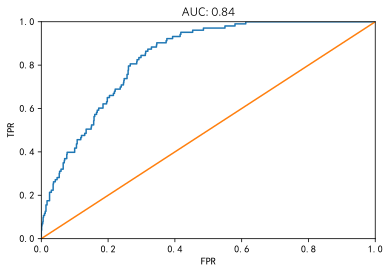

In [1323]:
from sklearn.metrics import roc_curve, roc_auc_score
FPR_sm,TPR_sm,thr_sm = roc_curve(y,p_smlr_best)
AUC_sm = roc_auc_score(y,p_smlr_best)
DrawROC(FPR_sm, TPR_sm, AUC_sm,'Statsmodels')

In [1446]:
conf_mat_sm = smlr_best.pred_table(0.5)

In [1447]:
conf_mat_sm

array([[ 926.,    5.],
       [  95.,    8.]])

In [1448]:
print('Precision:{:.2f}'.format(conf_mat_sm[1,1]/sum(conf_mat_sm[:,1])))
print('Recall:{:.2f}'.format(conf_mat_sm[1,1]/sum(conf_mat_sm[1,:])))

Precision:0.62
Recall:0.08


In [1419]:
smlr_best.params[smlr_best.pvalues < 0.05]

Intercept   -2.72e+00
团购评价         3.85e-01
市场价         -9.82e-03
在售时长         1.11e-03
图片数量         6.38e-02
辖区_登封市       1.43e+00
dtype: float64

### Sklearn method

In [1329]:
X_rm.columns

Index(['团购评价', '团购价', '市场价', '在售时长', '折扣率', '餐厅人均', '餐厅营业时长', '餐厅评分', '图片数量',
       '无免费WiFi', '有免费WiFi', '节假日通用', '非节假日通用', '不提供免费停车', '提供免费停车', '不可使用包间',
       '可使用包间', '不可叠加使用', '可叠加使用', '无需预约', '需要预约', '不限优惠券使用张数', '限制使用张数',
       '不限使用人数', '限制使用人数', '仅限堂食', '可以外带', '辖区_上街区', '辖区_中原区', '辖区_中牟县',
       '辖区_二七区', '辖区_巩义市', '辖区_惠济区', '辖区_新密市', '辖区_新郑市', '辖区_登封市', '辖区_管城区',
       '辖区_荥阳市', '辖区_金水区'],
      dtype='object')

In [1330]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_rm, y, stratify=y, random_state=0)

In [1347]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1',C=1,random_state=0)

In [1348]:
from sklearn.metrics import precision_score, recall_score, f1_score
# fit logistic regression
lr.fit(X_train,y_train)
# make predictions (0-1 prediction)
lr.predict(X_train)
# get model coefficients
# print(lr.coef_)
# get accuracy: (TP+TN)/(N+P)
print('Training set accuracy:{:.3f}'.format(lr.score(X_train,y_train)))
print('Test set accuracy:{:.3f}'.format(lr.score(X_test,y_test)))
# get prob. prediction
p_lr = lr.predict_proba(X_rm)[:,1]
# Calculate Precision, Recall and F1
y_pred = lr.predict(X_rm)
prec = precision_score(y,y_pred)
recall = recall_score(y,y_pred)
f1 = f1_score(y,y_pred)
print('Precision: {:.3f}, Recall: {:.3f}, F1-score: {:.3f}'.format(prec,recall,f1))

Training set accuracy:0.908
Test set accuracy:0.911
Precision: 0.765, Recall: 0.126, F1-score: 0.217


In [1349]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y,y_pred)

array([[927,   4],
       [ 90,  13]], dtype=int64)

In [1334]:
coef = lr.coef_.flatten()

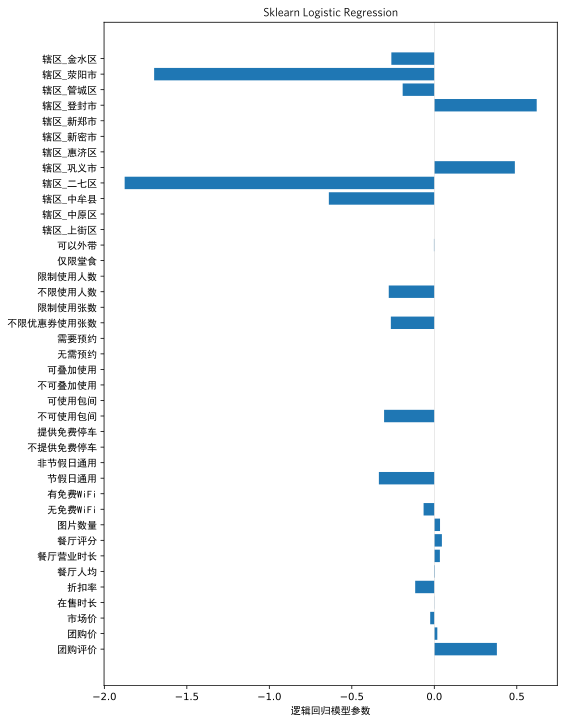

In [1337]:
plt.figure(figsize=(8,10))
plt.barh(list(range(len(coef))),coef)
plt.yticks(list(range(len(coef))),X_rm.columns)
plt.xlabel('逻辑回归模型参数')
plt.xticks(**{'fontname':'WhitneyBook Numeric'})
plt.axvline(x=0,c='lightgray',ls='-',lw=0.5)
plt.tight_layout()
plt.title('Sklearn Logistic Regression',**{'fontname':'Whitney Book'})
plt.show()
#plt.savefig('Logistic_model_params.png',dpi=600)

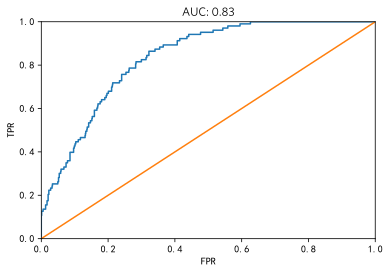

In [1338]:
FPR_sklog, TPR_sklog, thres_sklog = roc_curve(y,p_lr)
AUC_sklog = roc_auc_score(y,p_lr)
DrawROC(FPR_sklog, TPR_sklog, AUC_sklog, 'Scikit Learn')

## 决策树
* 适合上述这种imbalanced data问题

In [1369]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,make_scorer

In [1370]:
param_grid = {'max_leaf_nodes':range(2,25),'max_depth':range(2,8)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid,
                    scoring=make_scorer(f1_score),cv=5, return_train_score=True)
grid.fit(X_train, y_train)
# inspect best parameters, compute test-set accuracy
print('Best mean cross_validation score: %.3f'%(grid.best_score_))
print('Best Max_leaf_nodes: {}'.format(grid.best_params_))

Best mean cross_validation score: 0.319
Best Max_leaf_nodes: {'max_depth': 4, 'max_leaf_nodes': 19}


In [1371]:
dtcbest = grid.best_estimator_
dtcbest.fit(X_train,y_train)
print('Test set score: %.3f'%(dtcbest.score(X_test,y_test)))

Test set score: 0.900


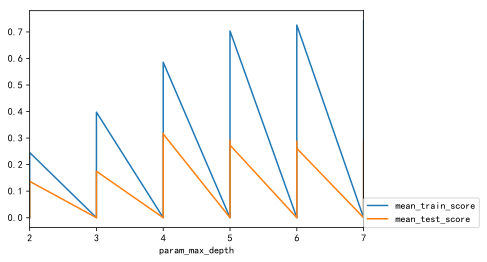

In [1372]:
scores = pd.DataFrame(grid.cv_results_)
plt.figure()
scores.plot(x='param_max_depth', y=['mean_train_score', 'mean_test_score'], ax=plt.gca())
plt.legend(loc=(1, 0))
plt.show()

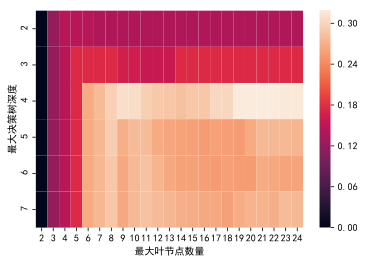

In [1373]:
scores = pd.DataFrame(grid.cv_results_)
plt.figure()
sns.heatmap(data = np.reshape(scores.mean_test_score,(6,23)))
plt.ylabel('最大决策树深度')
plt.yticks(np.arange(0,6,1)+0.5,np.arange(2,8,1))
plt.xlabel('最大叶节点数量')
plt.xticks(np.arange(0,23,1)+0.5,np.arange(2,25,1))
plt.show()

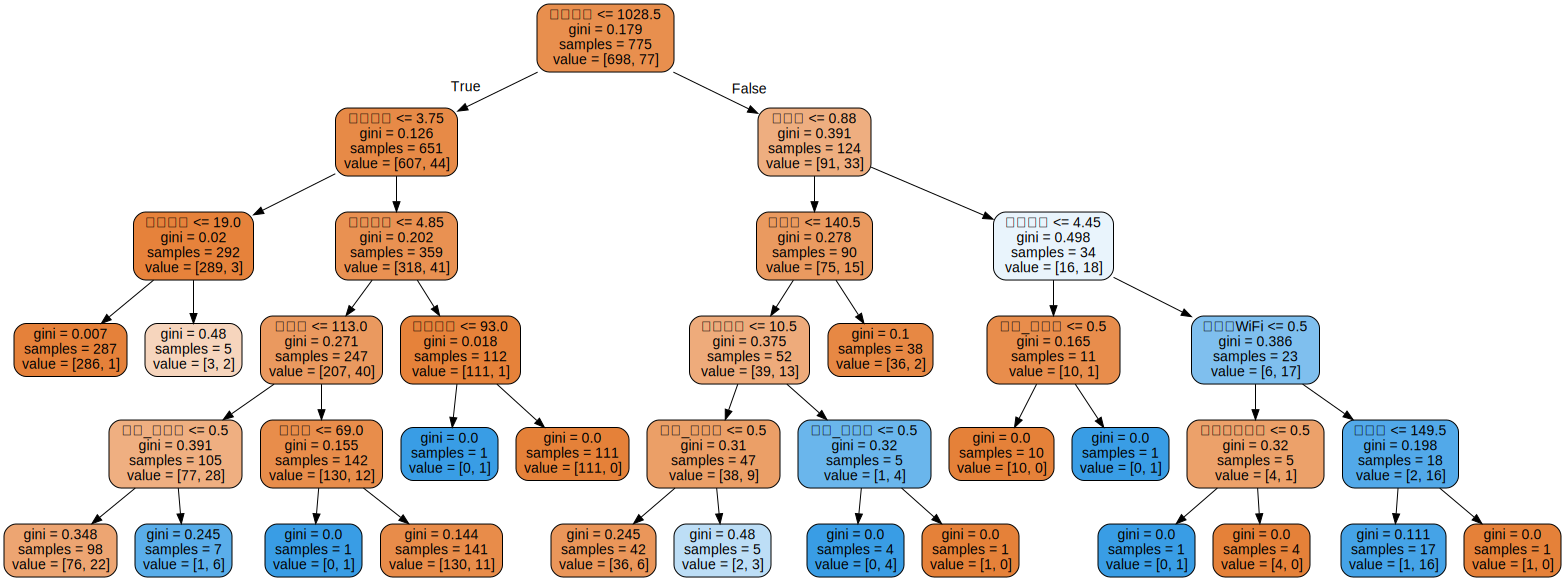

In [1374]:
from sklearn.tree import export_graphviz
import graphviz
tree_dot = export_graphviz(dtcbest, out_file=None, feature_names=X_rm.columns, filled=True, rounded=True)
graph = graphviz.Source(tree_dot)  
graph 
# # import from local py file
# from tree_plotting import plot_tree
# plot_tree(tree, feature_names=X.columns, filled=True)

In [1552]:
imp_feat_nm = X_rm.columns[dtcbest.feature_importances_>0]
imp_feat_val = dtcbest.feature_importances_[dtcbest.feature_importances_>0]
imp_feat = pd.DataFrame([imp_feat_nm, imp_feat_val]).T

In [1554]:
imp_feat.columns=['feature','importance']

In [1568]:
imp_feat.sort_values('importance',ascending=True,inplace=True)

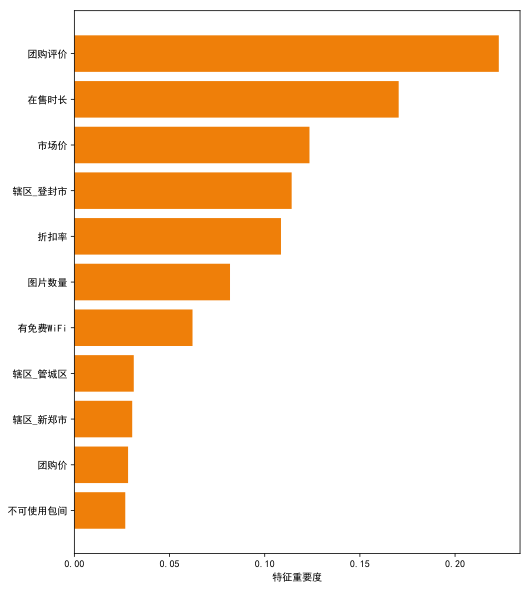

In [1586]:
# solution here ...
plt.figure(figsize=(8,10))
ax = plt.gca()
# ax.xaxis.set_ticks_position('top')
# ax.xaxis.set_label_position('top')
# sns.despine(ax=ax,top=False,bottom=True)
plt.barh(range(len(imp_feat)),imp_feat['importance'],color=C['orange'])
plt.yticks(range(len(imp_feat)),imp_feat['feature'])
#plt.xticks(**{'fontname':'WhitneyNumeric Book'})
plt.xlabel('特征重要度')
#plt.tight_layout()
plt.show()
plt.savefig('a.jpg',dpi=600)

In [1439]:
dtcbest.score(X_test,y_test)

0.89961389961389959

In [1376]:
p_dt = dtcbest.predict_proba(X_rm)[:,1]

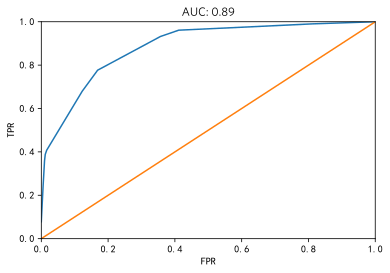

In [1377]:
FPR_dt,TPR_dt,thres_dt = roc_curve(y,p_dt)
AUC_dt = roc_auc_score(y,p_dt)
DrawROC(FPR_dt, TPR_dt, AUC_dt, 'Scikit Learn Decision tree')

In [1362]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [1379]:
y_pred_dt = dtcbest.predict(X_rm)

In [1544]:
dtcbest.feature_importances_

array([ 0.2229816 ,  0.02821644,  0.1235161 ,  0.17038385,  0.10854898,
        0.        ,  0.        ,  0.        ,  0.08176947,  0.        ,
        0.06207774,  0.        ,  0.        ,  0.        ,  0.        ,
        0.02674317,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03038997,
        0.11415877,  0.03121391,  0.        ,  0.        ])

In [1380]:
precision_score(y,y_pred_dt)

0.78431372549019607

In [1381]:
recall_score(y,y_pred_dt)

0.38834951456310679